Pruebas sobre el dataset 

In [ ]:
#%pip install rapidfuzz --quiet
#%pip install spacy --quiet


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
#%pip install wordcloud matplotlib --quiet


Note: you may need to restart the kernel to use updated packages.


### Librerías

In [94]:
import pandas as pd
import spacy
from collections import defaultdict
from pprint import pprint
import re
from unidecode import unidecode
from spacy.lang.es.stop_words import STOP_WORDS
import unicodedata
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np
import nltk
from gensim.models import Word2Vec
import gensim
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('punkt_tab')
import rapidfuzz

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\karen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [95]:
#!python -m spacy download es_core_news_md --quiet


# Cargar Corpus y formatear fechas

In [96]:
file_path = r"C:\Users\karen\Documents\HumanidadesDigitales_git\BDD_Corpus\Corpus_completo_revisado.xlsx"
corpus_completo = pd.read_excel(file_path)


In [97]:
# Formatear fechas

meses = {
    'enero': '01',
    'febrero': '02',
    'marzo': '03',
    'abril': '04',
    'mayo': '05',
    'junio': '06',
    'julio': '07',
    'agosto': '08',
    'septiembre': '09',
    'octubre': '10',
    'noviembre': '11',
    'diciembre': '12'
}

def convertir_fecha(fecha_str):
    partes = fecha_str.split(' de ')
    dia = partes[0].zfill(2)  # Asegura 2 dígitos para días 1-9
    mes = meses[partes[1]]
    año = partes[2]
    return f"{dia}/{mes}/{año}"  # Formato DD/MM/AAAA

corpus_completo['Fecha'] = corpus_completo['Fecha'].apply(convertir_fecha)
corpus_completo['Fecha'] = pd.to_datetime(corpus_completo['Fecha'], format='%d/%m/%Y', errors='coerce')

In [98]:
corpus_completo.head()

,Diario,Autor,Fecha,Título,Texto,Vínculo,ID
0,El Espectador,Gonzalo Hernández,2018-01-01,Fajardo: para nada tibio,"La Coalición Colombia –Partido Alianza Verde, ...",https://web.archive.org/web/20180102104221/htt...,1
1,El Espectador,Eduardo Barajas Sandoval,2018-01-01,Macedonia de Norte,Las interpretaciones de la historia sirven com...,https://web.archive.org/web/20180102104221/htt...,2
2,El Espectador,Daniel Emilio Rojas Castro,2018-01-01,El nacionalismo según Vargas Llosa,La semana pasada Mario Vargas Llosa publicó un...,https://web.archive.org/web/20180102104221/htt...,3
3,El Espectador,Reinaldo Spitaletta,2018-01-01,"Tiempo sagrado, tiempo profano","Pudiera decirse, sin ser una verdad absoluta, ...",https://web.archive.org/web/20180102104221/htt...,4
4,El Espectador,Aura Lucía Mera,2018-01-01,La rebelión de los bueyes,Lo mejor del encierro de Las Ventas fueron los...,https://web.archive.org/web/20180102104221/htt...,5


# Búsqueda exacta de  tesauros

In [122]:
textos = corpus_completo['Texto'].tolist()


In [123]:
nlp = spacy.load("es_core_news_md")

In [124]:
nlp.Defaults.stop_words |= {"tola","maruja","gazapera", "email protected"}

In [125]:
def preprocesar_texto(texto):
    # Limpieza
    texto = re.sub(r'http\S+|www\S+|https\S+', '', texto, flags=re.MULTILINE) # eliminar URLs
    texto = re.sub(r'\S+@\S+', '', texto) # eliminar correos electrónicos
    texto = re.sub(r'[^\w\sáéíóúñÁÉÍÓÚÑ]', ' ', texto) # mantener solo caracteres alfanuméricos y acentos
    
    # Procesamiento con spaCy tokenizacion
    doc = nlp(texto)
    
    # Lematización y filtrado
    tokens = [
        token.text for token in doc
        if not token.is_punct 
        and not token.is_stop
        and not token.is_space
        #and token.pos_ in ['NOUN', 'VERB', 'PROPN','ADJ', 'NUM']  # Tomar solo sustantivos, verbos, nombres propios, adjetivos y numerales
        and token.text.isalpha()  # Solo palabras alfabéticas
    ]
    
    return " ".join(tokens)
    

In [126]:
def limpieza(texto):

    
    texto = str(texto.lower())
    texto = re.sub(r'[\x00-\x1F\x7F-\x9F]', '', texto)
    texto = re.sub(r'http\S+|www\S+|https\S+', '', texto, flags=re.MULTILINE)  # Eliminar URLs
    texto = re.sub(r'\S+@\S+', '', texto) # eliminar correos electrónicos
    texto = re.sub(r'[^\w\sáéíóúñÁÉÍÓÚÑ]', ' ', texto) # mantener solo caracteres alfanuméricos y acentos
    texto = ''.join(c if c in 'ñÑ' else unicodedata.normalize('NFD', c)[0] for c in texto)
    #texto = texto.encode('ascii', 'ignore').decode('ascii')  # Solo ASCII
    texto = re.sub(r'\s+', ' ', texto).strip()  # Normalizar espacios
    
    return texto

textos_unicode = [limpieza(texto) for texto in textos]

In [127]:
diccionario_ciencia = ["cientific", "ciencia", "tecnologia", "experimento", "laboratorio"]
diccionario_ciencia = [limpieza(term) for term in diccionario_ciencia]
patron_busqueda = re.compile(r"\b(" + "|".join(diccionario_ciencia) + r")", flags=re.IGNORECASE)

diccionario_ciencia


['cientific', 'ciencia', 'tecnologia', 'experimento', 'laboratorio']

In [128]:
def busqueda_palabras(textos, palabras_busqueda, ventana=5, ventana_stopwords=10):
    patron = re.compile(r"\b(" + "|".join(palabras_busqueda) + r")", re.IGNORECASE)
    resultados = []
    
    # Inicialmente pregunta si el texto contiene alguna palabra de búsqueda
    for i, texto in enumerate(textos):
        palabras_original = texto.split()

        # Buscar en texto (rápido)
        if patron.search(texto):
            # Buscar posiciones exactas en original
            for match in patron.finditer(texto):
                inicio, fin = match.span()
                
                # Convertir posición de caracteres a índice de palabra
                palabras_antes = texto[:inicio].split() # contar palabras antes de la coincidencia 
                palabra_idx = len(palabras_antes) - 1 if palabras_antes else 0
                
                contexto = " ".join(palabras_original[max(0, palabra_idx-ventana):min(palabra_idx+ventana+1, len(palabras_original)+1)])

                antes_sin_stopwords = [word for word in palabras_antes if (word.lower() not in STOP_WORDS)]
                antes_sin_stopwords = list(set(antes_sin_stopwords[-ventana_stopwords:]))  # limitar a ventana de stopwords
                despues_sin_stopwords = [word for word in palabras_original[palabra_idx+2:len(palabras_original)+1] if (word.lower() not in STOP_WORDS)]
                despues_sin_stopwords = list(set(despues_sin_stopwords[:ventana_stopwords]))  # limitar a ventana de stopwords
                
                resultados.append({
                    'texto_index': i,
                    'palabra': match.group(),
                    'posicion_caracter': (inicio, fin),
                    'posicion_palabra': palabra_idx,
                    'contexto': contexto,
                    'Antes_sin_stopwords': antes_sin_stopwords,
                    'Despues_sin_stopwords': despues_sin_stopwords,
                    'metadata': corpus_completo.iloc[i][['Título', 'Autor', 'Fecha', 'ID', 'Diario']].to_dict()
                })
    resultados_df = pd.DataFrame(resultados)

    return resultados_df

In [183]:
#resultados = busqueda_palabras(textos_unicode, diccionario_ciencia, 20,10)
resultados = busqueda_palabras(textos_unicode, ['comision'], 20,10)
len(resultados)


1520

In [184]:
# Generar excel con resultados
resultados.to_excel("resultados_busqueda.xlsx", index=False)

In [185]:
todas_las_palabras = []
for lista in resultados['Antes_sin_stopwords']:
    todas_las_palabras.extend(lista)

for lista in resultados['Despues_sin_stopwords']:
    todas_las_palabras.extend(lista)

palabras_contexto = ' '.join(todas_las_palabras)

In [186]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(palabras_contexto)

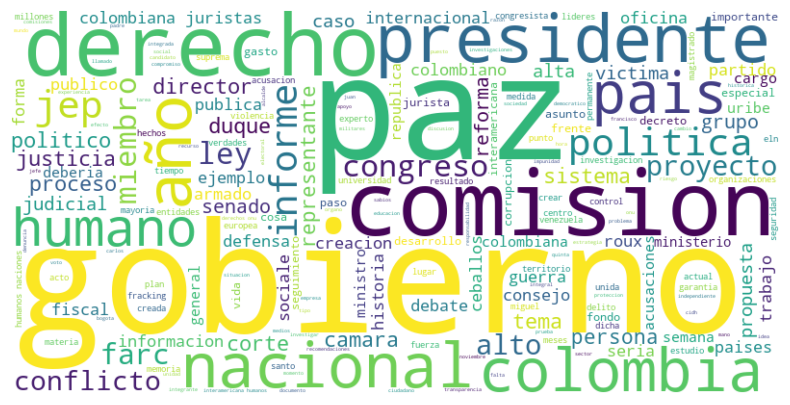

In [187]:
plt.figure(figsize=(10, 5)) # Ajusta el tamaño de la figura
plt.imshow(wordcloud, interpolation='bilinear') # Muestra la imagen de la nube de palabras
plt.axis('off') # Elimina los ejes
plt.show()

In [189]:
word_counter = Counter(palabras_contexto.split())
word_counter.most_common(50)

[('paz', 222),
 ('gobierno', 213),
 ('comision', 172),
 ('derechos', 171),
 ('humanos', 155),
 ('presidente', 147),
 ('nacional', 133),
 ('colombia', 118),
 ('pais', 107),
 ('jep', 94),
 ('años', 87),
 ('informe', 83),
 ('congreso', 81),
 ('colombiana', 80),
 ('justicia', 79),
 ('alto', 77),
 ('ley', 74),
 ('juristas', 74),
 ('farc', 70),
 ('camara', 70),
 ('politica', 65),
 ('duque', 64),
 ('director', 63),
 ('conflicto', 62),
 ('corte', 56),
 ('personas', 56),
 ('sistema', 52),
 ('interamericana', 51),
 ('año', 50),
 ('miembros', 50),
 ('senado', 50),
 ('general', 48),
 ('victimas', 48),
 ('proceso', 48),
 ('naciones', 47),
 ('judicial', 47),
 ('sociales', 45),
 ('acusaciones', 45),
 ('roux', 44),
 ('onu', 44),
 ('internacional', 44),
 ('reforma', 44),
 ('proyecto', 43),
 ('unidas', 43),
 ('tema', 42),
 ('seguridad', 42),
 ('consejo', 41),
 ('ceballos', 40),
 ('informacion', 39),
 ('creacion', 38)]

# Búsqueda semántica de tesauros

In [51]:
def obtener_original(id, corpus):
    return corpus[corpus['ID'] == id]

In [52]:
# Dividir texto en párrafos

# Lista para almacenar los resultados
parrafos = []

# Iterar sobre cada fila del dataframe
for idx, row in corpus_completo.iterrows():
    texto = row['Texto']
    id_corpus = row['ID']  
    nombre = row['Título']
    
    if pd.notnull(texto):
        segmentos = texto.split('\n')
        for segmento in segmentos:
            if segmento.strip() and len(segmento) > 40:  # Solo agregar segmentos no vacíos
                parrafos.append({
                    'ID_corpus': id_corpus,
                    'texto_segmentado': segmento.strip(),
                    'titulo': nombre,
                    'autor' : row['Autor'],
                    'fecha' : row['Fecha'],
                    'indice_original': idx
                })

# Crear el nuevo dataframe
tabla_parrafos = pd.DataFrame(parrafos)

In [53]:
tabla_parrafos

,ID_corpus,texto_segmentado,titulo,autor,fecha,indice_original
0,1,"La Coalición Colombia –Partido Alianza Verde, ...",Fajardo: para nada tibio,Gonzalo Hernández,2018-01-01,0
1,1,Fajardo diagnostica a Colombia como un país fr...,Fajardo: para nada tibio,Gonzalo Hernández,2018-01-01,0
2,1,"Promete un liderazgo hacia la reconciliación, ...",Fajardo: para nada tibio,Gonzalo Hernández,2018-01-01,0
3,1,La energía y el énfasis de sus presentaciones ...,Fajardo: para nada tibio,Gonzalo Hernández,2018-01-01,0
4,1,"Esto no debe, sin embargo, generar confusiones...",Fajardo: para nada tibio,Gonzalo Hernández,2018-01-01,0
...,...,...,...,...,...,...
109377,13337,"Sin embargo, la solicitud de anexión fue recha...",Casanare y el bicentenario,Julio Londoño Paredes,2018-12-28,13336
109378,13337,El secretario del congreso venezolano fue Sant...,Casanare y el bicentenario,Julio Londoño Paredes,2018-12-28,13336
109379,13337,Las condiciones del congreso venezolano para r...,Casanare y el bicentenario,Julio Londoño Paredes,2018-12-28,13336
109380,13337,Aunque Colombia todavía no estaba consagrada a...,Casanare y el bicentenario,Julio Londoño Paredes,2018-12-28,13336


In [54]:
# Generar embeddings de textos
#modelo_embedding = SentenceTransformer('hiiamsid/sentence_similarity_spanish_es')
modelo_embedding = SentenceTransformer('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')

In [21]:
texto_segmentado_list = tabla_parrafos['texto_segmentado'].astype(str).tolist()[:2000]

In [22]:
embeddings = modelo_embedding.encode(texto_segmentado_list, convert_to_tensor=False).astype('float32')

In [93]:
indice = faiss.IndexFlatL2(embeddings.shape[1])
indice.add(embeddings)

NameError: name 'embeddings' is not defined

In [24]:
diccionario_ciencia

['cientific', 'ciencia', 'tecnologia', 'experimento', 'laboratorio']

In [91]:
def resultados_busqueda_semantica(diccionario, k):
        # Buscar texto similar a una consulta 
    resultados_busqueda_semantica = []
    for w in diccionario_ciencia:
        consulta = w
        embedding_consulta = modelo_embedding.encode(consulta, convert_to_tensor=False).astype('float32')
        embedding_consulta = np.array([embedding_consulta])  # FAISS espera una matriz 2D
        distancias, indices = indice.search(embedding_consulta, k = 2000)
        percentile = np.percentile(distancias[0],70)
        for i, d in enumerate(distancias[0]):
            if d > percentile:
                resultados_busqueda_semantica.append(
                    {
                        'consulta': w,
                        'texto_segmentado': texto_segmentado_list[indices[0][i]],
                        'distancia': d,
                        'ID_corpus': tabla_parrafos.iloc[indices[0][i]]['ID_corpus'],
                        'metadata': tabla_parrafos.iloc[indices[0][i]][['ID_corpus', 'titulo', 'autor', 'fecha', 'indice_original']].to_dict()
                    }
                )
    resultados_busqueda_semantica_df = pd.DataFrame(resultados_busqueda_semantica)
    return resultados_busqueda_semantica_df

In [92]:
r3 = resultados_busqueda_semantica(["comision"],50)

NameError: name 'indice' is not defined

In [ ]:
resultados_busqueda_semantica_df.groupby('consulta').size()

consulta
ciencia        600
cientific      600
experimento    600
laboratorio    600
tecnologia     600
dtype: int64

In [28]:
resultados_busqueda_semantica_df[resultados_busqueda_semantica_df['ID_corpus'] == 12]

,consulta,texto_segmentado,distancia,ID_corpus,metadata
232,cientific,Permítanme ahora remitirme al sobrino de la ví...,13.396679,12,"{'ID_corpus': 12, 'titulo': 'Julio Sánchez y M..."
444,cientific,http://jorgegomezpinilla. blogspot.com.co,14.213885,12,"{'ID_corpus': 12, 'titulo': 'Julio Sánchez y M..."
945,ciencia,Permítanme ahora remitirme al sobrino de la ví...,9.911924,12,"{'ID_corpus': 12, 'titulo': 'Julio Sánchez y M..."
1070,ciencia,http://jorgegomezpinilla. blogspot.com.co,10.375779,12,"{'ID_corpus': 12, 'titulo': 'Julio Sánchez y M..."
1331,tecnologia,Ese día los oyentes despertaron escandalizados...,12.606810,12,"{'ID_corpus': 12, 'titulo': 'Julio Sánchez y M..."
1364,tecnologia,"Ya para concluir, está lo que le pregunté a Ma...",12.716633,12,"{'ID_corpus': 12, 'titulo': 'Julio Sánchez y M..."
1376,tecnologia,De otro lado: ¿cuál equilibrio puede haber e...,12.749008,12,"{'ID_corpus': 12, 'titulo': 'Julio Sánchez y M..."
1616,tecnologia,http://jorgegomezpinilla. blogspot.com.co,13.472363,12,"{'ID_corpus': 12, 'titulo': 'Julio Sánchez y M..."
1617,tecnologia,A tan aberrante paradoja intenté darle explica...,13.476939,12,"{'ID_corpus': 12, 'titulo': 'Julio Sánchez y M..."
1684,tecnologia,Permítanme ahora remitirme al sobrino de la ví...,13.850063,12,"{'ID_corpus': 12, 'titulo': 'Julio Sánchez y M..."


In [29]:
pprint(len(resultados_busqueda_semantica_df.iloc[416].texto_segmentado))

476


# Word2Vec

In [155]:
corpus = corpus_completo['Texto'].tolist()
corpus = ' '.join(corpus)

In [156]:
sents = [word_tokenize(sentence.lower()) for sentence in nltk.sent_tokenize(corpus)]

In [157]:
len(sents)

332069

In [158]:
model_word2vec_skipgram = Word2Vec(sents, vector_size=50, window=5, min_count=1, sg=1)

In [159]:
model_word2vec_skipgram.wv.most_similar("escritor")

[('novelista', 0.9101418256759644),
 ('pensador', 0.8985159993171692),
 ('pintor', 0.8965883255004883),
 ('filósofo', 0.8902847170829773),
 ('músico', 0.8859150409698486),
 ('artista', 0.8809692859649658),
 ('poeta', 0.8753626346588135),
 ('cronista', 0.8740599155426025),
 ('creador', 0.8724374175071716),
 ('dramaturgo', 0.8720893859863281)]

In [160]:
model_word2vec_skipgram.wv.most_similar("escritora")

[('filósofa', 0.8729516267776489),
 ('historiadora', 0.8607221245765686),
 ('antropóloga', 0.8479127883911133),
 ('autora', 0.8401401042938232),
 ('bailarina', 0.8291873931884766),
 ('bellísima', 0.8290979862213135),
 ('profesora', 0.82614666223526),
 ('mary', 0.8231053352355957),
 ('biografía', 0.8214443325996399),
 ('condé', 0.8198272585868835)]

In [161]:
model_word2vec_skipgram.wv.most_similar("científico")

[('teórico', 0.8869382739067078),
 ('estético', 0.859853982925415),
 ('lingüístico', 0.8543165922164917),
 ('innovador', 0.8503625988960266),
 ('didáctico', 0.8488225340843201),
 ('filosófico', 0.8472633361816406),
 ('canon', 0.8460785150527954),
 ('académico', 0.841256320476532),
 ('matemático', 0.8406558632850647),
 ('cinematográfico', 0.8397543430328369)]

In [162]:
model_word2vec_skipgram.wv.most_similar("científica")

[('empírica', 0.8986928462982178),
 ('matemática', 0.8694231510162354),
 ('teórica', 0.8671112656593323),
 ('académica', 0.8565104007720947),
 ('analítica', 0.8522235155105591),
 ('evolutiva', 0.8489565849304199),
 ('detallada', 0.8462902307510376),
 ('deportiva', 0.841895580291748),
 ('específica', 0.8372562527656555),
 ('tecnológica', 0.8365077972412109)]

In [163]:
model_word2vec_skipgram.wv.most_similar("faciolince", topn=20)

[('baute', 0.9280905723571777),
 ('rolando', 0.9254714846611023),
 ('lope', 0.9224720001220703),
 ('escultor', 0.9204839468002319),
 ('bonnett', 0.915608286857605),
 ('poe', 0.9148218631744385),
 ('escalona', 0.9142916202545166),
 ('héctor', 0.9139602780342102),
 ('silvia', 0.9122286438941956),
 ('vladdo', 0.911996066570282),
 ('obituario', 0.9096173048019409),
 ('saramago', 0.9093033671379089),
 ('juana', 0.9080753326416016),
 ('vanessa', 0.9079314470291138),
 ('helena', 0.9072036147117615),
 ('burgos', 0.9050410389900208),
 ('abad', 0.9034540057182312),
 ('nicanor', 0.9033663868904114),
 ('tatiana', 0.901695728302002),
 ('proust', 0.9016510248184204)]